In [7]:
# imports
import numpy as np
import sympy as sy
import pandas as pd
import re

import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib.ticker import PercentFormatter
from matplotlib import rcParams
import scipy.constants as pc
from sympy import *
from math import log10, floor
from math import *
import math

from scipy.optimize import curve_fit
from scipy.optimize import minimize

rcParams['font.size'] = 15
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['axes.grid'] = True
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams["xtick.minor.size"] =  4
rcParams["ytick.minor.size"] =  4
rcParams["xtick.minor.visible"] =  True
rcParams["ytick.minor.visible"] =  True

In [8]:
# Funktionen
def am(werte):
    return np.mean(werte)

def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

def stu(werte):
    return std(werte)/np.sqrt(werte.size)

def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def fehlerMax(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += dif * unsicherheiten[i]
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def groessterBeitrag(f, werte, unsicherheiten, variablen):
    zMax = 0
    zMaxArray = np.array([])
    for i in range (werte.size):
        zMax = (np.abs(sy.diff(f, variablen[i])) * unsicherheiten[i])
        for j in range(werte.size):
            zMax = sub(zMax, variablen[j], werte[j])
        x = np.array([zMax])
        zMaxArray = np.append(zMaxArray, x)
    return variablen[np.argmax(zMaxArray)], zMaxArray[np.argmax(zMaxArray)]

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (koeffizienten[i]*unsicherheiten[i])**2
    return sqrt(dz)

def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

def einfachGaussMultMax(unsicherheiten, werte, exponenten):
    max_a = 0
    num = -1
    for i in range (unsicherheiten.size):
        maxi = (exponenten[i]*unsicherheiten[i]/werte[i])**2
        if max_a <= maxi:
            max_a = maxi
            num = i
    return (max_a, num)

def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)*(stu_2**2))))

def bestA(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

def bestB(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestA(x, y)+bestB(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

def stuA(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))

def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

def round_to_j(x,j):
    return round(x, (j-1)-int(floor(log10(abs(x)))))

def print_to_table(avgs, stds, rows, cols,
                   highlight_best=True,
                   max_is_best=True,
                   avg_format='{0:!>4.1f}',
                   std_format='{1:!<4.1f}',
                   file=None,
                   col_orientation='c'):
    # Find best values
    best_avg = {}
    if highlight_best:
        if max_is_best:
            for c in cols:
                idx = np.argmax(avgs[c], axis=0)
                best_avg[c] = idx
        else:
            for c in cols:
                idx = np.argmin(avgs[c], axis=0)
                best_avg[c] = idx

    # Header
    print_str = '\\begin{tabular}{l' + (" "+col_orientation) * len(cols) + '} \hline\n'
    for c in cols:
        print_str += ' & ' + c
    print_str += ' \\\\ \n \hline'

    # Content
    for m in range(len(rows)):
        row_name = rows[m]
        print_str += '\n{0}'.format(row_name)
        for c in cols:
            print_str += ' &\n '
            print_list = [avgs[c][m]]
            print_list += [stds[c][m]]
            if m == best_avg.get(c, None):
                print_str += ('$\mathbf{{'+ avg_format + ' \\pm ' + std_format + '}}$').format(*print_list)
            else:
                print_str += ('$'+ avg_format + ' \\pm ' + std_format + '$').format(*print_list)

        print_str += "\n \\vspace*{0.0mm} \\\\"
        print_str = print_str.replace('!', '\\phantom{0}')

    # Footer
    print_str += '\n \hline \n \end{tabular}'

    # Write output
    if file is None:
        print(print_str)
    else:
        with open(file, 'w') as f:
            f.write(print_str)

In [9]:
#numerische Minimierung; parameterFinden(); Programm hängt sich nicht auf, dauert nur ordentlich lange

'''def chiQuadrat(xWerte, yWerte, funktion):
    #print(xWerte)
    #print(yWerte)
    #print(funktion)
    chiQ = 0
    unsich = std(yWerte)
    for i in range(xWerte.size):
        mp = sub(funktion, x, xWerte[i])
        #print(mp)
        chiQ += (yWerte[i]-mp)**2/unsich**2
        #print(chiQ)
    return chiQ'''

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])


def chiQuadrat(xWerte, yWerte, yUnsicherheit, funktion):
    chiQ = 0
    for i in range(xWerte.size):
        mp = sub(funktion, x, xWerte[i])
        chiQ += (yWerte[i]-mp)**2/(yUnsicherheit[i])**2
    return chiQ


def comb(a,b):
    c = np.array([[a[0],b[0]]])
    for i in a:
        for j in b:
            if (j != b[0] and i!=a[0]):
                c = np.concatenate((c,np.array([[i,j]])),axis=0)
    return c


def numMinChiQuadrat(parameter, xWerte, yWerte, yUnsicherheit, funktion, paramedics):#parameter:array;xWerte:array;yWerte:array;yUnsicherheiten:array,funktion:function;paramedics:array von arrays
    numMin = 200000
    bestpara = np.empty(parameter.size,dtype=float)
    tupel = paramedics[0]

    for b in range(parameter.size):
        if b!=0:
            tupel = comb(tupel,paramedics[b])
    for combi in tupel:
        funktioni = funktion
        for para in range(combi.size):
            funktioni = sub(funktioni,parameter[para],combi[para])
            
        vergleich = chiQuadrat(xWerte, yWerte, yUnsicherheit, funktioni)
        if np.array_equal(combi,tupel[0]):
            numMin = vergleich
            bestpara = combi
        if vergleich<numMin:
            numMin = vergleich
            bestpara = combi
    return bestpara, numMin


def parameterFinden(parameter,     #Symbols als array
                    xWerte,        #xWerte als array
                    yWerte,        #yWerte als array
                    yUnsicherheit, #yUnsicherheiten als array
                    funktion,      #funktion aus ParameterSymbols, mit xSymbol
                    bereiche,      #bereiche als array von arrays mit Höchst- und Tiefswerte in selber Reihenfolge wie die parameter. !!Bereiche möglichst gut schätzen!! Sonst ist chiquadrat evtl verfälscht.
                    tiefe):        #Größenordnung wir genau. Eins höher, 1 Zehntel kleinerer Bereich, !!exponentieller Anstieg der Dauer!! 3 oder 4 reicht meist aus.
    while(tiefe>0):
        genau = 20*tiefe
        bereich = np.array([np.linspace(bereiche[0][0],bereiche[0][1],genau)])
        for i in range(parameter.size):
            if i != 0:
                bereich = np.concatenate((bereich,np.array([np.linspace(bereiche[i][0],bereiche[i][1],genau)])),axis=0)
        bestpara, numMin = numMinChiQuadrat(parameter, xWerte, yWerte, yUnsicherheit, funktion, bereich)
        for i in range(parameter.size):
            for j in range(genau):
                if bestpara[i] == bereich[i][j]:
                    bereiche[i][0] = (bereich[i][j]-np.abs((bereiche[i][1]-bereiche[i][0])/(genau*1.5)))
                    bereiche[i][1] = (bereich[i][j]+np.abs((bereiche[i][1]-bereiche[i][0])/(genau*1.5)))
        tiefe -=1
    return bestpara, numMin

In [10]:
# Erinnerungen Keine Ahgnunh was das ist nicht öffnen
 #

#ax.plot(x, y, color='tab:bue', label=r'label')
#ax.scatter(x, y, color='tab:red', label=r'label')
#ax.errorbar(am_x, am_y, xerr=std_x, yerr=std_y, capsize='5', 
#            ecolor=['tab:blue','tab:red'], fmt='none', color='tab:blue', label=r'label')
# x = np.array([,])
# x.size
# x, y = symbols('x y')
# expr = x*y
# expr.subs([(x, wert_x), (y, wert_y)])

In [16]:
#load data
df = pd.read_csv("Messung_daempfung_HM1508.csv")

# Convert DataFrame columns to NumPy arrays
ch_a_array = df['CH A'].to_numpy()
fake_daempfung = ch_a_array * 0.01
time_array = df['Time'].to_numpy()

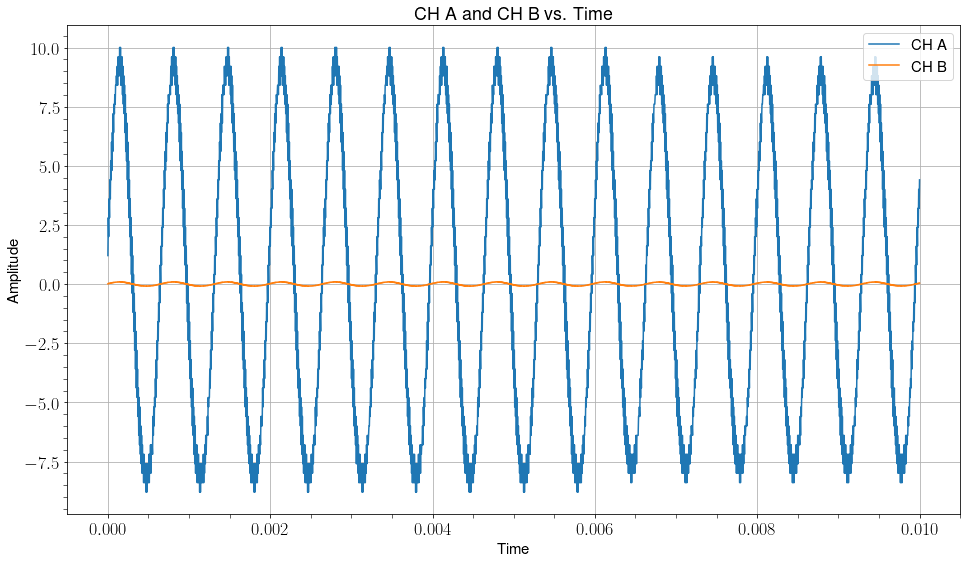

In [20]:
#Plot daempfung
plt.figure(figsize=(16, 9))  # Adjust the figure size as needed
plt.scatter(time_array, ch_a_array, label='CH A',marker=None)
plt.scatter(time_array, fake_daempfung, label='CH B',marker=None)

# Add labels and a legend
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

# Show the plot
plt.grid(True)
plt.title('CH A and CH B vs. Time')
plt.show()